# Neural Network Example

In [ ]:
# !pip install torch torchvision

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import BloodMNIST, INFO
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_theme(style="whitegrid", context="paper")
%config InlineBackend.figure_format = "retina"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 3 * 28 * 28  # 3 channels x 28 pixels x 28 pixels

lr = 1e-3
epochs = 50
batch_size = 128
dropout_rate = 0.7
hidden_dims = [256, 256, 128]

# Data
info = INFO["bloodmnist"]
n_classes = len(info["label"])

transform = transforms.Compose(
  [
    transforms.ToTensor(),  # Cast to tensor in range [0, 1]
    transforms.Normalize(mean=[.5], std=[.5])  # Zero mean and [-1, 1] range
  ]
)

# Dataset
train_dataset = BloodMNIST(split="train", transform=transform, download=True)
val_dataset = BloodMNIST(split="val", transform=transform, download=True)
test_dataset = BloodMNIST(split="test", transform=transform, download=True)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Using downloaded and verified file: /home/alonsolml/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/alonsolml/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/alonsolml/.medmnist/bloodmnist.npz


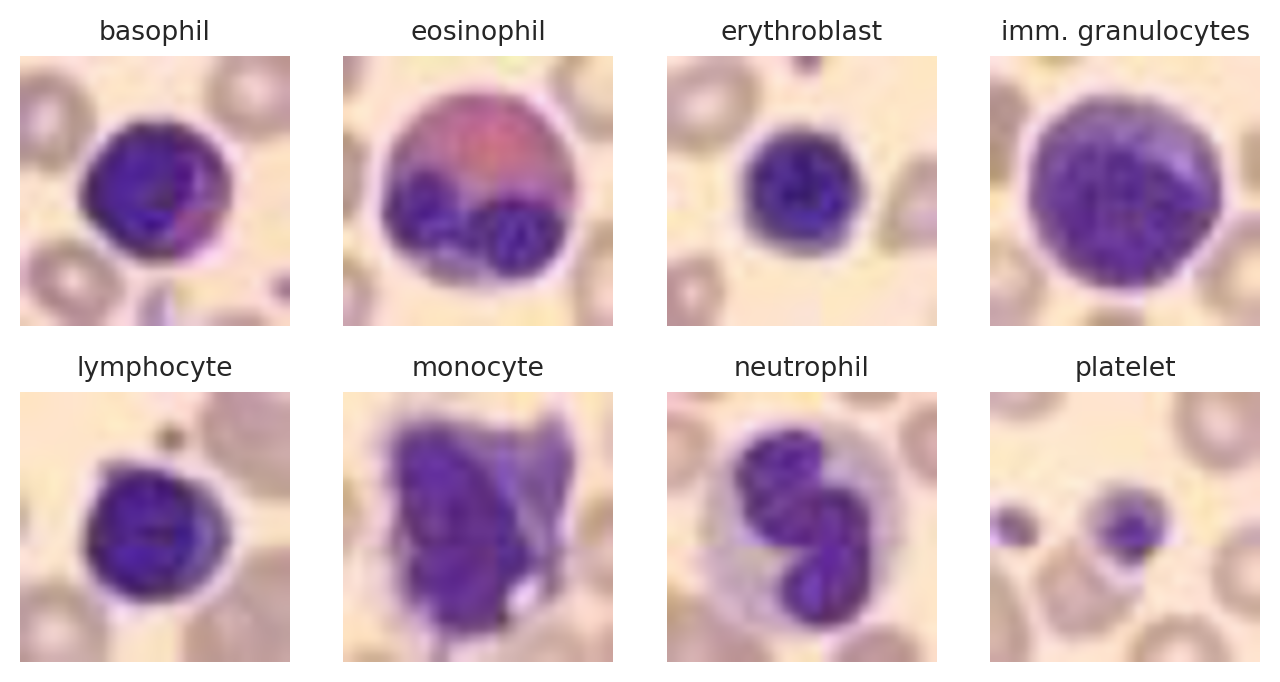

In [ ]:
display_labels = [
  "basophil",
  "eosinophil",
  "erythroblast",
  "imm. granulocytes",
  "lymphocyte",
  "monocyte",
  "neutrophil",
  "platelet"
]

label_idx = dict(zip(*np.unique(val_dataset.labels, return_index=True)))
fig, axes = plt.subplots(nrows=2, ncols=n_classes//2, figsize=(8, 4))
for ax, (label, idx) in zip(axes.flatten(), label_idx.items()):
  ax.imshow(val_dataset.imgs[idx], interpolation="gaussian")
  ax.set_title(display_labels[label])
  ax.axis("off")

In [4]:
class MLP(nn.Module):
  def __init__(
    self,
    hidden_dims=[256, 256, 128],
    input_dim=3*28*28,
    n_classes=8
  ):
    super().__init__()
    self.net = nn.Sequential(
      nn.Flatten(),
      # First hidden layer
      nn.Linear(input_dim, hidden_dims[0]),
      nn.BatchNorm1d(hidden_dims[0]),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Second hidden layer
      nn.Linear(hidden_dims[0], hidden_dims[1]),
      nn.BatchNorm1d(hidden_dims[1]),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Third hidden layer
      nn.Linear(hidden_dims[1], hidden_dims[2]),
      nn.BatchNorm1d(hidden_dims[2]),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Output layer
      nn.Linear(hidden_dims[2], n_classes)
    )

  def forward(self, x):
    return self.net(x)

In [5]:
model = MLP(hidden_dims, input_dim, n_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
def train_step():
  model.train()  # Set model to train mode
  total_loss = 0.0
  for x, y in train_loader:
    x, y = x.to(device), y.squeeze().long().to(device)
    output = model(x)
    loss = loss_fn(output, y)
    # Backpropagation
    loss.backward()
    optimizer.step()  # Update model parameters
    optimizer.zero_grad()  # Reset gradients of model parameters
    total_loss += loss.item() * x.shape[0]  # Weighted loss
  return total_loss / len(train_loader.dataset)  # Average loss

def evaluate(loader):
  model.eval()  # Set model to evaluation mode
  correct = 0  # Start counting
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.squeeze().long().to(device)
      output = model(x)
      preds = output.argmax(dim=1)
      correct += (preds == y).sum().item()
  return correct / len(loader.dataset)  # Accuracy


In [7]:
train_losses = []
train_scores = []
val_scores = []
for epoch in range(epochs):
  loss = train_step()
  train_score = evaluate(train_loader)
  val_score = evaluate(val_loader)
  train_losses.append(loss)
  train_scores.append(train_score)
  val_scores.append(val_score)
  if epoch % (epochs // 10) == 0:
    print(f"Epoch {epoch}: Train loss: {loss:.4f}, Validation Acc. = {val_score:.4f}")

test_score = evaluate(test_loader)
print(f"Test Accuracy: {test_score:.4f}")

Epoch 0: Train loss: 1.5676, Validation Acc. = 0.6776
Epoch 5: Train loss: 0.7468, Validation Acc. = 0.8125
Epoch 10: Train loss: 0.6395, Validation Acc. = 0.7944
Epoch 15: Train loss: 0.5876, Validation Acc. = 0.8207
Epoch 20: Train loss: 0.5663, Validation Acc. = 0.8429
Epoch 25: Train loss: 0.5215, Validation Acc. = 0.8329
Epoch 30: Train loss: 0.5064, Validation Acc. = 0.8516
Epoch 35: Train loss: 0.4928, Validation Acc. = 0.8633
Epoch 40: Train loss: 0.4638, Validation Acc. = 0.8598
Epoch 45: Train loss: 0.4341, Validation Acc. = 0.8674
Test Accuracy: 0.8524


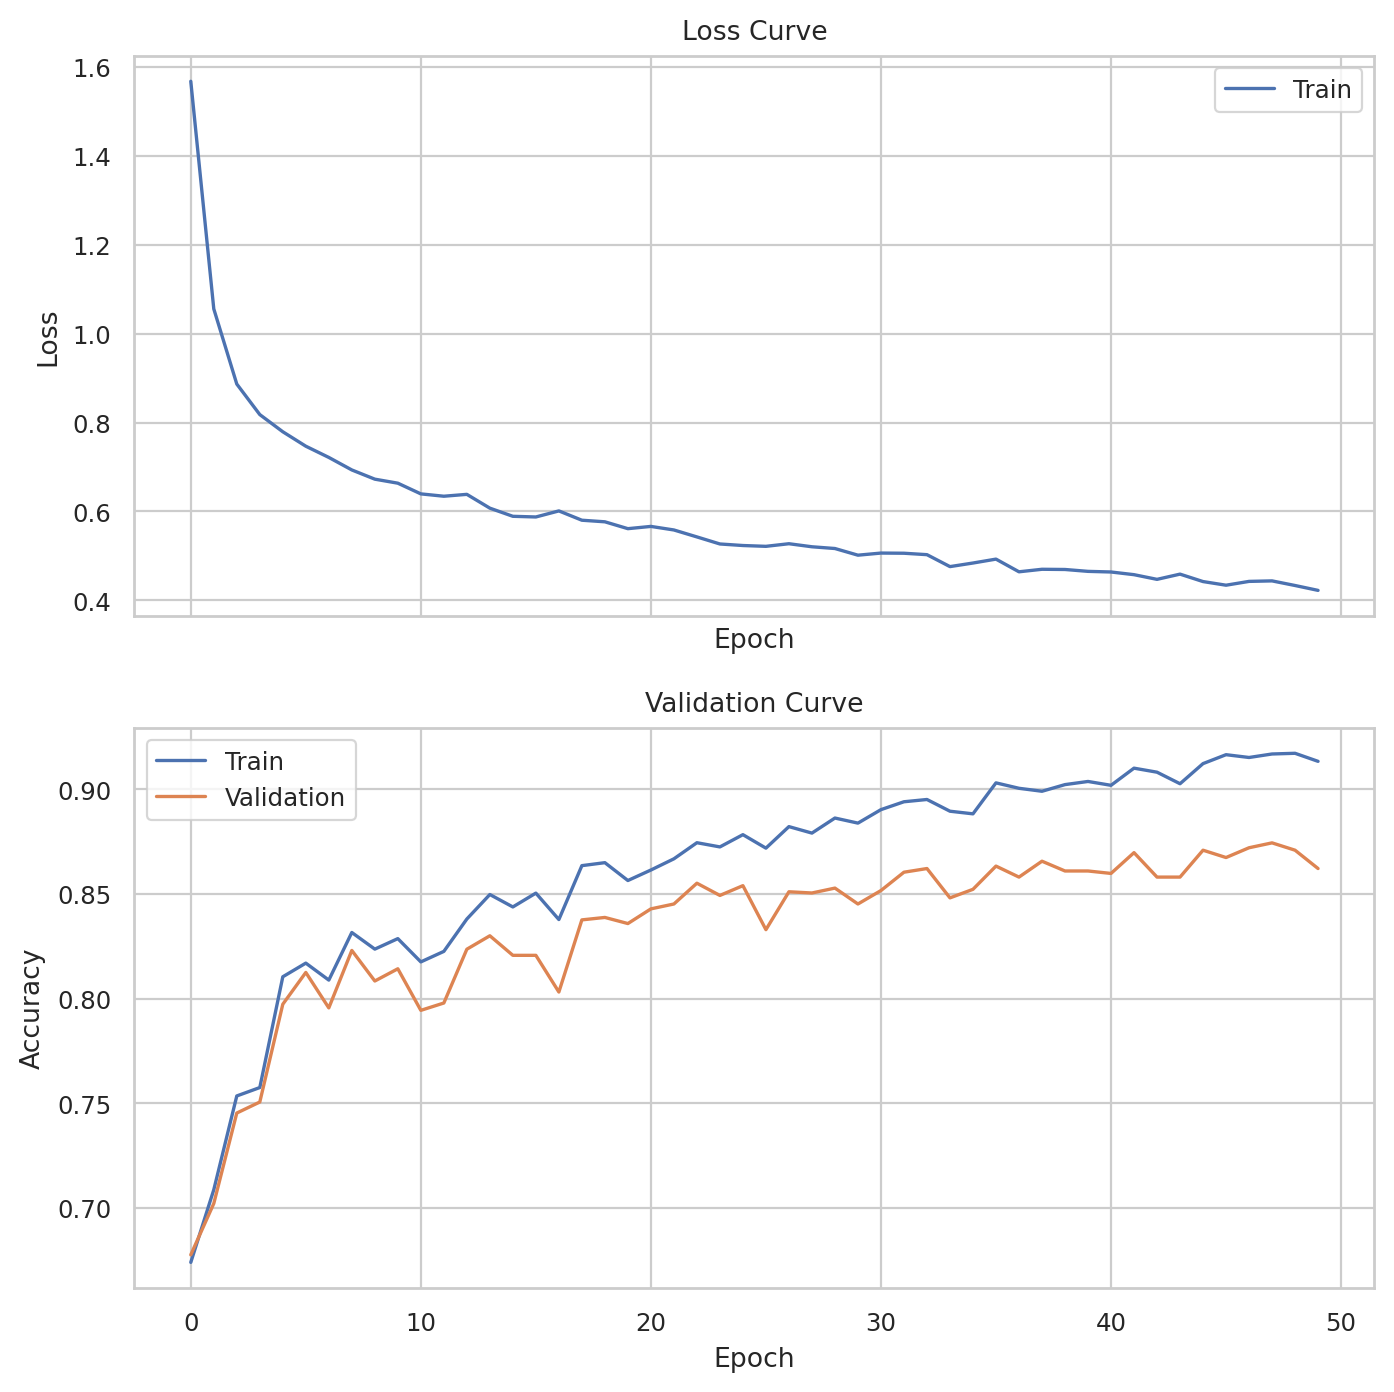

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax1.plot(train_losses, label="Train")
ax1.set(
  xlabel="Epoch",
  ylabel="Loss",
  title="Loss Curve"
)
ax1.legend()
ax2.plot(train_scores, label="Train")
ax2.plot(val_scores, label="Validation")
ax2.legend()
ax2.set(
  xlabel="Epoch",
  ylabel="Accuracy",
  title="Validation Curve"
)

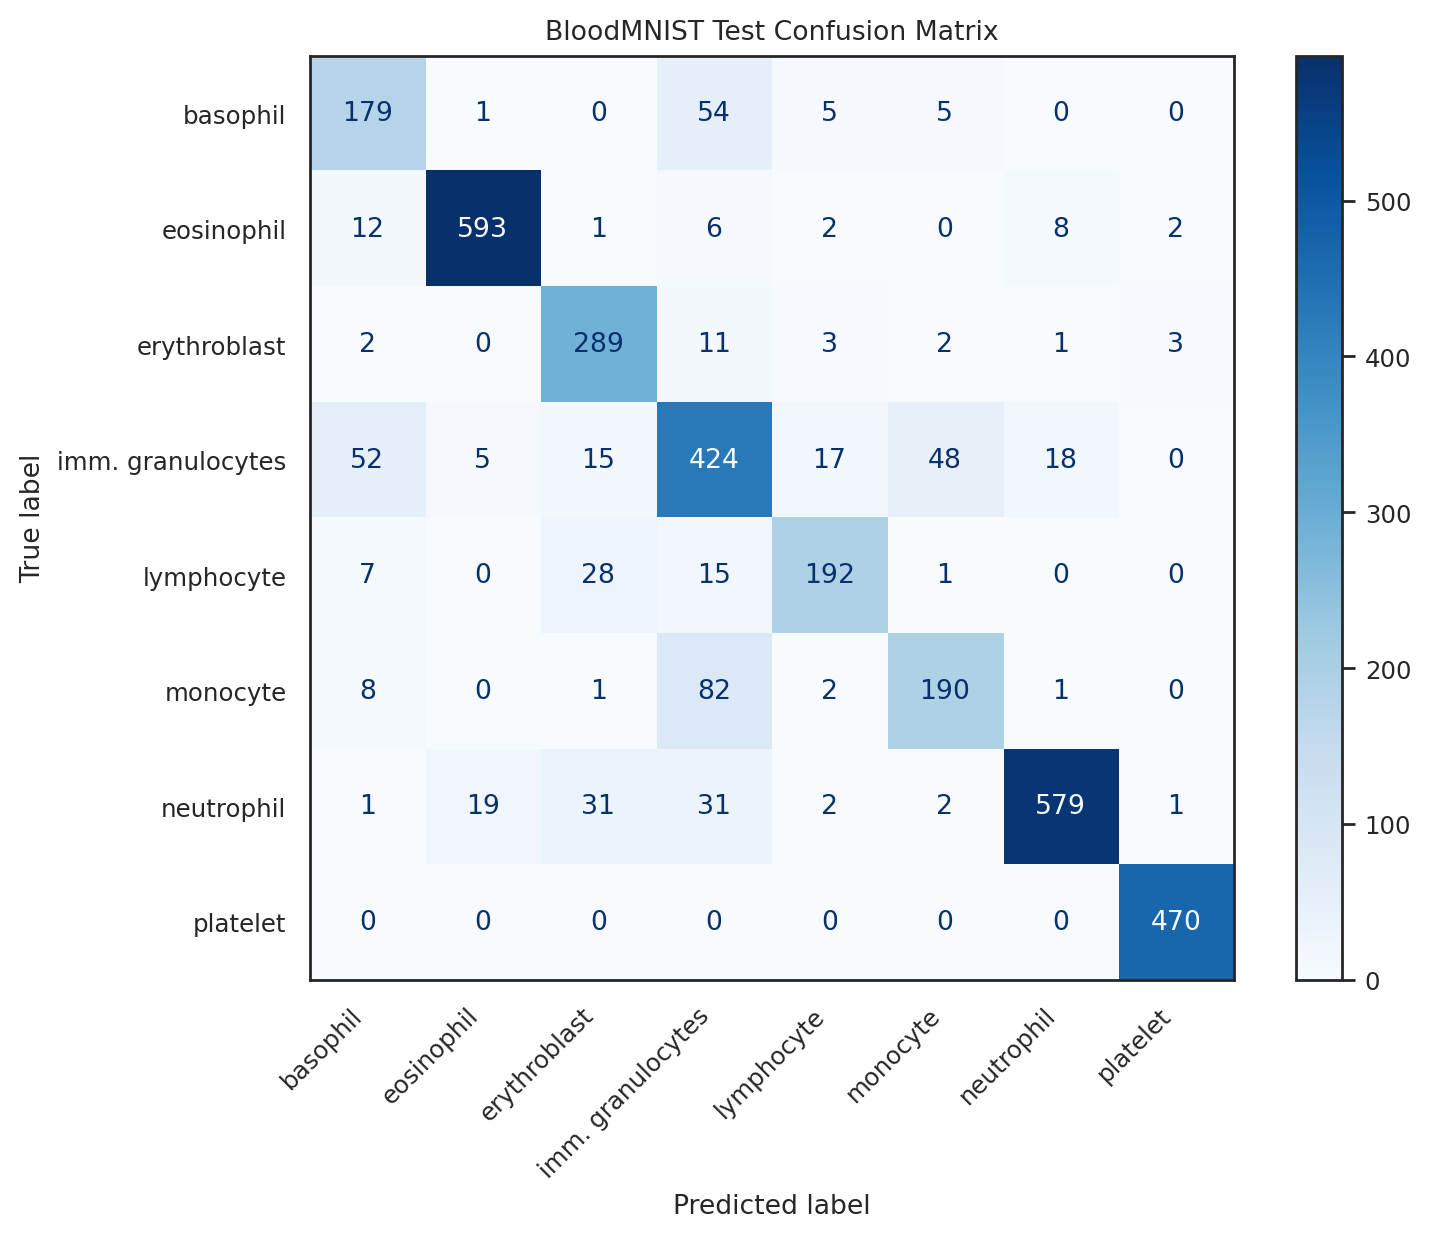

In [ ]:
model.eval()
with torch.no_grad():
  predictions = []
  labels = []
  for x, y in test_loader:
    x, y = x.to(device), y.squeeze().long().to(device)
    output = model(x)
    pred = output.argmax(dim=1)
    predictions.extend(pred.cpu().numpy())
    labels.extend(y.cpu().numpy())

with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(8, 6))
  disp = ConfusionMatrixDisplay.from_predictions(
    y_true=labels,
    y_pred=predictions,
    display_labels=display_labels,
    cmap="Blues",
    ax=ax
  )
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_title(f"BloodMNIST Test Confusion Matrix")